In [330]:
import yfinance as yf
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
import seaborn
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from datetime import timedelta
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', InterpolationWarning)


In [297]:
# Define the list of symbols to analyze
symbol_list = ['^SPX', 'AFK', 'BRF', 'ECH', 'ECNS', 'EEM', 'EIDO', 'EIS', 'ENZL', 'EPHE', 'EPI', 'EPU', 'EWA', 'EWC', 'EWD' ,'EWG', \
               'EWH', 'EWI', 'EWJ', 'EWK', 'EWL', 'EWM', 'EWN', 'EWO', 'EWP', 'EWQ' ,'EWS' ,'EWT' , 'EWU' ,'EWV', 'EWW', 'EWY', 'EWZ', 'EWZS', \
                'EZA', 'FXI', 'FXP', 'GXC', 'IDX', 'ILF', 'INDY', 'PGJ', 'THD', 'TUR', 'VNM']
#EGPT not alive
# Download historical data for the symbols
data = yf.download(symbol_list, start='2006-01-01', end='2024-05-01')['Adj Close']

[*********************100%%**********************]  45 of 45 completed


In [298]:
log_return = np.log(data / data.shift(1))

In [299]:
from sklearn.model_selection import train_test_split
training_set, validation_set = train_test_split(data, test_size = 0.3, random_state = 1, shuffle = False)

In [300]:
def adf_test(timeseries):
    pvalue = adfuller(timeseries, autolag="AIC")[1]
    return pvalue

def kpss_test(timeseries):
    pvalue = kpss(timeseries, regression="c", nlags="auto")[1]
    return pvalue

In [301]:
col = ['leg1', 'leg2', 'u ~ I(0)', 'leg1 ~ I(1)', 'leg2 ~ I(1)', 'beta1', 'beta2', 'pvalue1', 'pvalue2']

info_table = []
residuals = {}
n = training_set.shape[1]
for i in range(n):
    for j in range(i+1, n):
        leg1 = symbol_list[i]
        leg2 = symbol_list[j]

        S1 = training_set[leg1].dropna()
        S2 = training_set[leg2].dropna()

        tidx = S1.index.intersection(S2.index)

        S1 = S1.loc[tidx]
        S2 = S2.loc[tidx]

        mod = sm.OLS(S1, sm.add_constant(S2, prepend=False))
        res = mod.fit()

        info = [symbol_list[i], symbol_list[j]]
        if adf_test(res.resid) < 0.05:
            info.append(True)
            
            residuals[leg1 + '+' +leg2] = data[leg1] - res.params.iloc[1] - res.params.iloc[0] * data[leg2]
        else:
            continue

        if adf_test(S1) > 0.05 and kpss_test(S1) < 0.05:
            info.append(True)
        else:
            info.append(False)

        if adf_test(S2) > 0.05 and kpss_test(S2) < 0.05:
            info.append(True)
        else:
            info.append(False)
            
        

        delta_y = np.log(S1 / S1.shift(1)).dropna()
        delta_x = np.log(S2 / S2.shift(1)).dropna()

        mod = sm.OLS(delta_y, pd.concat([delta_x, res.resid.shift(1).loc[delta_x.index]], axis=1))
        ecm = mod.fit()

        info = info + [ecm.params.iloc[0], ecm.params.iloc[1], ecm.pvalues.iloc[0], ecm.pvalues.iloc[1]]
        
        info_table.append(info)
    print(i)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


In [302]:
info_table = pd.DataFrame(info_table, columns = col)

In [303]:
condition1 = info_table['leg1 ~ I(1)'] == True
condition2 = info_table['leg2 ~ I(1)'] == True
condition3 = info_table['pvalue1'] < 0.05
condition4 = info_table['pvalue2'] < 0.05

pass_test = info_table[condition1 & condition2 & condition3 & condition4].reset_index(drop = True)
residuals = pd.DataFrame(residuals)

pairs = pass_test['leg1'] + '+' + pass_test['leg2']
residuals = residuals[pairs]
pass_test.index = pairs

In [304]:
residuals

,BRF+EWL,BRF+EWV,BRF+EWZS,ECH+EWZS,ECH+ILF,ECNS+EIS,ECNS+ENZL,ECNS+EPI,ECNS+EWD,ECNS+EWG,...,EWZS+IDX,EWZS+ILF,FXI+INDY,FXI+THD,FXP+GXC,FXP+PGJ,FXP+THD,GXC+INDY,GXC+PGJ,INDY+PGJ
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-24,12.353227,0.808127,-4.600861,-11.465589,-15.240151,-22.837222,-15.587925,-42.814648,-29.082244,-18.615085,...,6.123921,-3.239175,-29.962840,-6.161149,-620.318069,-995.344147,-424.452673,-73.424442,7.689824,26.791054
2024-04-25,11.998828,0.668290,-4.530861,-11.313225,-15.190602,-22.100262,-15.444546,-43.195435,-28.480607,-18.397594,...,6.029014,-3.291227,-30.148004,-5.969154,-600.331189,-983.043945,-430.875827,-74.149601,7.782195,27.094511
2024-04-26,12.610737,1.150853,-4.748137,-11.857711,-15.761779,-21.907605,-14.559592,-42.659118,-28.142207,-17.964816,...,6.841463,-3.363785,-29.549768,-5.569147,-536.411480,-935.827335,-423.797851,-72.336632,7.885962,26.621840


In [305]:
pass_test

,leg1,leg2,u ~ I(0),leg1 ~ I(1),leg2 ~ I(1),beta1,beta2,pvalue1,pvalue2
BRF+EWL,BRF,EWL,True,True,True,0.982209,-0.000166,1.916277e-210,2.116869e-03
BRF+EWV,BRF,EWV,True,True,True,-0.402855,-0.000218,8.822589e-134,3.091016e-04
BRF+EWZS,BRF,EWZS,True,True,True,0.909156,-0.000311,0.000000e+00,8.732800e-03
ECH+EWZS,ECH,EWZS,True,True,True,0.420863,-0.000200,5.841182e-199,6.024648e-03
ECH+ILF,ECH,ILF,True,True,True,0.527893,-0.000109,0.000000e+00,1.923317e-02
...,...,...,...,...,...,...,...,...,...
FXP+PGJ,FXP,PGJ,True,True,True,-1.855957,-0.000002,0.000000e+00,5.168221e-11
FXP+THD,FXP,THD,True,True,True,-1.636343,-0.000003,0.000000e+00,1.023718e-12
GXC+INDY,GXC,INDY,True,True,True,0.666444,-0.000105,7.560791e-308,2.779273e-03
GXC+PGJ,GXC,PGJ,True,True,True,0.934684,-0.000167,0.000000e+00,3.148944e-05


<Axes: xlabel='Date'>

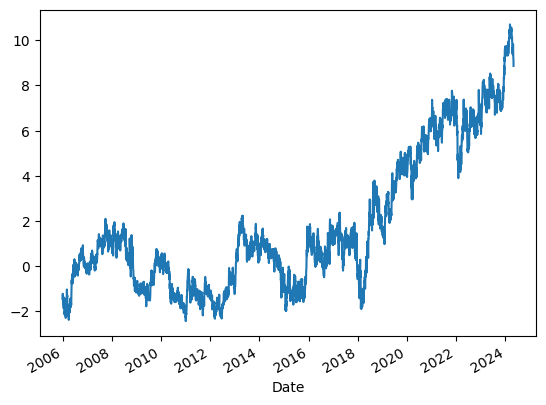

In [306]:
residuals.iloc[:,48].plot()

In [307]:
# Calculate RSI
def calculate_rsi(prices, period=30):
    delta = prices.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.ewm(com=period - 1, min_periods=period).mean()
    avg_loss = loss.ewm(com=period - 1, min_periods=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [308]:
residuals_rsi = calculate_rsi(residuals)

In [385]:
residuals_rsi.tail()

,BRF+EWL,BRF+EWV,BRF+EWZS,ECH+EWZS,ECH+ILF,ECNS+EIS,ECNS+ENZL,ECNS+EPI,ECNS+EWD,ECNS+EWG,...,EWZS+IDX,EWZS+ILF,FXI+INDY,FXI+THD,FXP+GXC,FXP+PGJ,FXP+THD,GXC+INDY,GXC+PGJ,INDY+PGJ
Date,,,,,,,,,,,,,,,,,,,,,
2024-04-24,43.175458,40.999880,52.967921,58.308213,54.608207,52.717182,51.295725,42.290461,49.313079,47.272090,...,47.438747,46.332427,55.062400,61.036101,55.371778,51.310113,43.874383,51.387759,58.592241,52.050176
2024-04-25,41.893209,40.074699,54.182688,59.114602,54.880664,54.689205,52.183063,40.992812,51.611639,48.510200,...,46.634977,45.613271,53.984206,61.990040,56.314534,52.219191,43.513736,49.966764,59.019082,53.835084
2024-04-26,44.820273,44.542179,50.033190,55.169814,51.214770,55.194568,57.165838,43.517965,52.855608,50.884228,...,53.597441,44.614699,56.810753,63.895167,59.168190,55.517258,44.038117,53.306195,59.504191,50.788719
2024-04-29,45.700608,45.377625,50.590054,59.050818,53.530694,55.128455,56.709353,44.130543,53.243571,53.039836,...,49.846191,41.734447,56.792625,64.878543,60.684553,55.871470,44.487344,53.225430,62.120298,52.116930
2024-04-30,41.962274,42.130287,54.451342,59.747577,55.469385,55.904090,58.130996,44.909025,56.738455,54.959302,...,45.880882,45.024129,54.588082,60.579685,56.871536,51.301902,43.311108,52.237922,62.756438,52.623129


In [309]:
buy_sell_signal = (residuals_rsi < 30) * 1 + (residuals_rsi > 70) * -1
buy_sell_signal = buy_sell_signal.replace(0, np.nan).ffill()


In [386]:
buy_sell_signal

,BRF+EWL,BRF+EWV,BRF+EWZS,ECH+EWZS,ECH+ILF,ECNS+EIS,ECNS+ENZL,ECNS+EPI,ECNS+EWD,ECNS+EWG,...,EWZS+IDX,EWZS+ILF,FXI+INDY,FXI+THD,FXP+GXC,FXP+PGJ,FXP+THD,GXC+INDY,GXC+PGJ,INDY+PGJ
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-24,1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0
2024-04-25,1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0
2024-04-26,1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0


In [310]:
profit = pd.DataFrame()
for i in pairs:

    position = buy_sell_signal[i]
    pass_test.loc[i].beta1

    pairs_log_return = log_return[pass_test.loc[i].leg1] - log_return[pass_test.loc[i].leg2] * pass_test.loc[i].beta1
    profit = pd.concat([profit, (position.shift(1) * pairs_log_return)], axis = 1)

<Axes: xlabel='Date'>

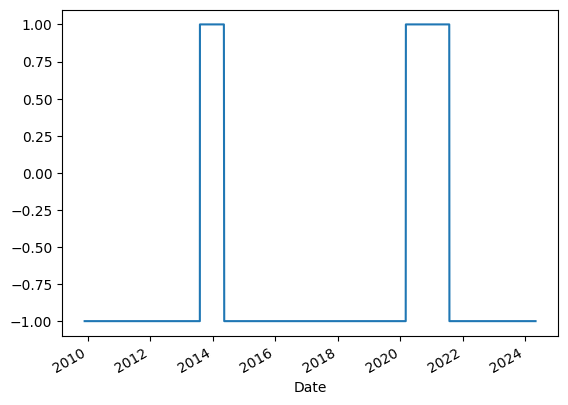

In [387]:
position.plot()

In [311]:
profit.columns = pairs

In [338]:
profit.index = pd.to_datetime(profit.index)

In [339]:
split_date = validation_set.index[0]

Text(0.5, 1.0, 'Equity Curve | Sharpe Ratio = 0.42 | Maximum Drawdown = 10.77% | Profitability = 51.22%')

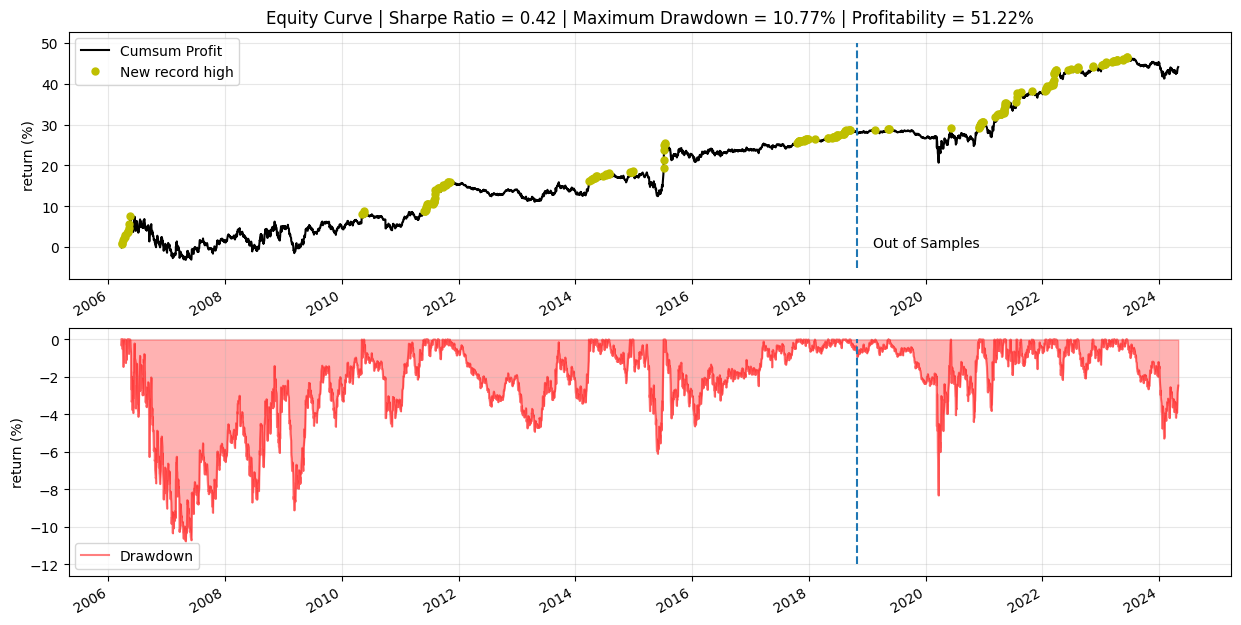

In [384]:
ec_ = profit.cumsum().mean(axis = 1).dropna() * 100
pnl = ec_.diff(1)

fig, axes = plt.subplots(2, 1, figsize=(15, 8))
ec_.plot(ax=axes[0], color='black')
cumProfit = ec_.cummax()
cumProfit = (cumProfit-cumProfit.shift(1)).replace(0, np.nan)+cumProfit.shift(1)
cumProfit.plot(ax=axes[0], style='yo',markersize=5)

profitability = (pnl > 0).sum() / len(pnl) * 100
axes[0].grid(alpha=0.3)

axes[0].set_ylabel('return (%)')
axes[0].legend(['Cumsum Profit', 'New record high'])
axes[0].vlines(split_date, -5, 50, linestyles = 'dashed')
axes[0].text(split_date + timedelta(100), 0, 'Out of Samples')
dd = ec_ - ec_.cummax()
dd.plot(ax=axes[1], color='r', alpha = 0.5)
axes[1].fill_between(dd.index, 0, dd, color='r', alpha = 0.3)
axes[1].grid(alpha=0.3)
axes[1].legend(['Drawdown'])
axes[1].set_ylabel('return (%)')
axes[1].vlines(split_date, -12, 0, linestyles = 'dashed')

annual_rtn = ((100 + ec_.iloc[-1]) / 100) ** (252 / len(ec_)) - 1
annual_std = (pnl / 100).std() * np.sqrt(252)
sr = annual_rtn / annual_std

axes[0].set_title(f"Equity Curve | Sharpe Ratio = {sr:.2f} | Maximum Drawdown = {- dd.min():.2f}% | Profitability = {profitability:.2f}%")

In [356]:
daily_profit = (ec_ - ec_.shift(1)).to_frame('return')
daily_profit["month"] = daily_profit.index.to_period("M").to_timestamp()
monthly_profit = daily_profit.groupby(['month']).sum()

Text(0, 0.5, 'return (%)')

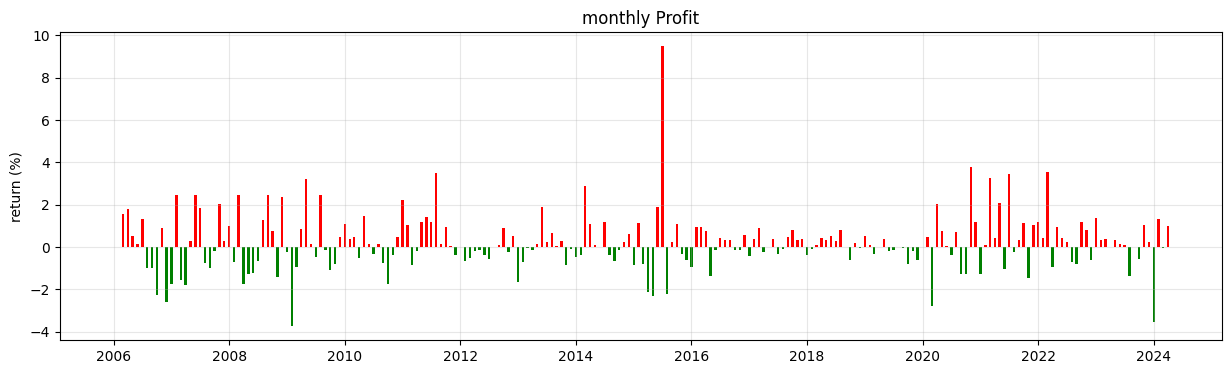

In [361]:
fig = plt.figure(figsize=(15,4))
plt.title('monthly Profit')
plt.bar(monthly_profit.index, monthly_profit.values.reshape(-1) * (monthly_profit.values.reshape(-1) > 0), width=15, color = 'r')
plt.bar(monthly_profit.index, monthly_profit.values.reshape(-1) * (monthly_profit.values.reshape(-1) < 0), width=15, color = 'g')

plt.grid(alpha = 0.3)
plt.ylabel('return (%)')

In [367]:
daily_profit["Year"] = daily_profit.index.to_period("Y-DEC").to_timestamp()
yearly_profit = daily_profit[['return', 'Year']].groupby(['Year']).sum()
yearly_profit.index = yearly_profit.index.strftime('%Y')
yearly_profit

,return
Year,
2006,-0.668187
2007,2.230140
2008,3.212627
2009,-0.299131
2010,0.385319
2011,10.241303
2012,-1.187577
2013,-0.348530
2014,4.065560


Text(0, 0.5, 'Return (%)')

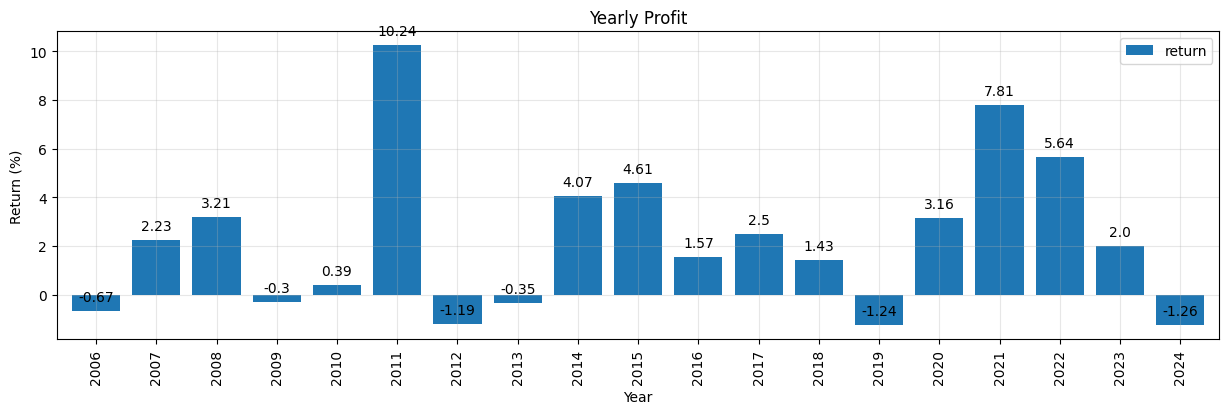

In [368]:
ax=yearly_profit.plot(kind='bar',title='Yearly Profit',width=0.8,figsize=(15,4))

for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
# ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
# ax.set_xticklabels(weekly_profit.index, rotation=0)
plt.grid(alpha=0.3) 
plt.ylabel('Return (%)') 